# Algorithmic Trading Model for Simple Moving Average Crossover Grid Search
### David Lowe
### June 25, 2020

## Task 1. Prepare Environment

In [1]:
!pip install python-dotenv PyMySQL

In [2]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


In [3]:
import os
import sys
import smtplib
import numpy as np
import pandas as pd
import requests
import json
from email.message import EmailMessage
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dotenv import load_dotenv

In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose = True

# Set up the sendNotification flag to send progress emails (setting True will send emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useColab = True
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
# pd.set_option("display.width", 140)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
stock_symbol = 'AAPL'
initial_capital = 0

# Specify the parameters for the trading strategy
fast_ma_min = 5
fast_ma_max = 20
slow_ma_min = 10
slow_ma_max = 50
ma_increment = 5
min_ma_gap = 5

model_start_date = datetime(2019, 1, 1)
print("Starting date for the model:", model_start_date)
stock_start_date = model_start_date - timedelta(days=int(slow_ma_max*1.5)) # Need more pricing data to calculate moving averages

model_end_date = datetime.now()
model_end_date = datetime(2020, 6, 29)
print("Ending date for the model:", model_end_date)

Starting date for the model: 2019-01-01 00:00:00
Ending date for the model: 2020-06-29 00:00:00


## Task 2. Acquire and Pre-Process Data

In [6]:
# Check and see whether the API key is available
quandl_key = os.environ.get('QUANDL_API')
if quandl_key is None: sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

In [7]:
start_date_string = stock_start_date.strftime('%Y-%m-%d')
end_date_string = model_end_date.strftime('%Y-%m-%d')

quandl_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s" % (start_date_string, end_date_string, stock_symbol, quandl_key)

In [8]:
response = requests.get(quandl_url)
quandl_dict = json.loads(response.text)
stock_quandl = pd.DataFrame(quandl_dict['datatable']['data'])
print(len(stock_quandl), 'data points retrieved from the API call.')
if verbose: print(quandl_dict)

426 data points retrieved from the API call.
{'datatable': {'data': [['AAPL', '2020-06-29', 353.25, 362.174, 351.28, 361.78, 32182306.0, 0.0, 361.78, '2020-06-29'], ['AAPL', '2020-06-26', 364.41, 365.32, 353.02, 353.63, 51314211.0, 0.0, 353.63, '2020-06-26'], ['AAPL', '2020-06-25', 360.7, 365.0, 357.57, 364.84, 34055508.0, 0.0, 364.84, '2020-06-25'], ['AAPL', '2020-06-24', 365.0, 368.79, 358.52, 360.06, 47745585.0, 0.0, 360.06, '2020-06-24'], ['AAPL', '2020-06-23', 364.0, 372.38, 362.27, 366.53, 53038869.0, 0.0, 366.53, '2020-06-25'], ['AAPL', '2020-06-22', 351.34, 359.46, 351.15, 358.87, 33509659.0, 0.0, 358.87, '2020-06-23'], ['AAPL', '2020-06-19', 354.635, 356.56, 345.15, 349.72, 66118952.0, 0.0, 349.72, '2020-06-19'], ['AAPL', '2020-06-18', 351.41, 353.45, 349.22, 351.73, 23605308.0, 0.0, 351.73, '2020-06-18'], ['AAPL', '2020-06-17', 355.15, 355.4, 351.09, 351.59, 28601626.0, 0.0, 351.59, '2020-06-17'], ['AAPL', '2020-06-16', 351.46, 353.2, 344.72, 352.08, 41109013.0, 0.0, 352.08, 

In [9]:
stock_quandl.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend', 'closeunadj', 'lastupdated']
# stock_quandl.set_index('date', inplace=True)
stock_quandl.index = pd.to_datetime(stock_quandl.date)
stock_quandl = stock_quandl.sort_index(ascending = True)
stock_quandl.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 426 entries, 2018-10-18 to 2020-06-29
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ticker       426 non-null    object 
 1   date         426 non-null    object 
 2   open         426 non-null    float64
 3   high         426 non-null    float64
 4   low          426 non-null    float64
 5   close        426 non-null    float64
 6   volume       426 non-null    float64
 7   dividend     426 non-null    float64
 8   closeunadj   426 non-null    float64
 9   lastupdated  426 non-null    object 
dtypes: float64(7), object(3)
memory usage: 36.6+ KB


In [10]:
stock_quandl.head()

,ticker,date,open,high,low,close,volume,dividend,closeunadj,lastupdated
date,,,,,,,,,,
2018-10-18,AAPL,2018-10-18,217.86,219.74,213.00,216.02,32581315.0,0.0,216.02,2020-05-01
2018-10-19,AAPL,2018-10-19,218.06,221.26,217.43,219.31,33078726.0,0.0,219.31,2020-05-01
2018-10-22,AAPL,2018-10-22,219.79,223.36,218.94,220.65,28792082.0,0.0,220.65,2020-05-01
2018-10-23,AAPL,2018-10-23,215.83,223.25,214.70,222.73,38767846.0,0.0,222.73,2020-05-01
2018-10-24,AAPL,2018-10-24,222.60,224.23,214.54,215.09,40925163.0,0.0,215.09,2020-05-01


In [11]:
stock_quandl.tail()

,ticker,date,open,high,low,close,volume,dividend,closeunadj,lastupdated
date,,,,,,,,,,
2020-06-23,AAPL,2020-06-23,364.00,372.380,362.27,366.53,53038869.0,0.0,366.53,2020-06-25
2020-06-24,AAPL,2020-06-24,365.00,368.790,358.52,360.06,47745585.0,0.0,360.06,2020-06-24
2020-06-25,AAPL,2020-06-25,360.70,365.000,357.57,364.84,34055508.0,0.0,364.84,2020-06-25
2020-06-26,AAPL,2020-06-26,364.41,365.320,353.02,353.63,51314211.0,0.0,353.63,2020-06-26
2020-06-29,AAPL,2020-06-29,353.25,362.174,351.28,361.78,32182306.0,0.0,361.78,2020-06-29


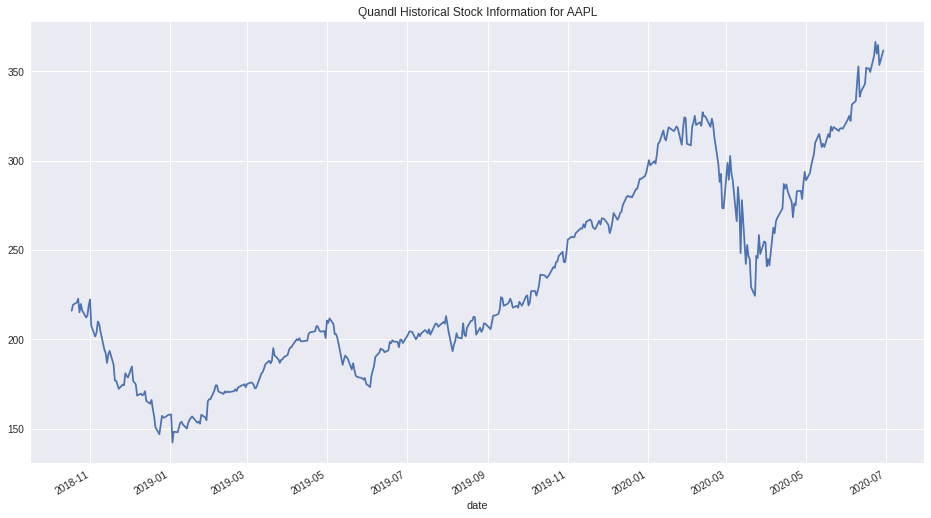

In [12]:
title_string = 'Quandl Historical Stock Information for ' + stock_symbol
stock_quandl['close'].plot(figsize=(16,9), title=title_string)
plt.show()

## Task 3. Develop Strategy and Train Model

### 3.a) Set up the Dataframe for the Trading Model

In [13]:
# Select the data source and pricing columns to use for modeling
# trading_model = stock_yahoo.loc[:, ['Open','Adj Close']]
# trading_model = stock_alpha.loc[:, ['open','adj_close']]
model_template = stock_quandl.loc[:, ['open','close']]
# trading_model = stock_quandl.loc[start_date:end_date, ['Adj_Close']]

# Set up the standard column name for modeling
model_template.rename(columns={'open': 'open_price', 'close': 'close_price'}, inplace=True)
if verbose: model_template.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 426 entries, 2018-10-18 to 2020-06-29
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open_price   426 non-null    float64
 1   close_price  426 non-null    float64
dtypes: float64(2)
memory usage: 10.0 KB


In [14]:
if verbose: model_template.head()

In [15]:
if verbose: model_template.tail()

### 3.b) Set up the Analysis Table with Indicators

In [16]:
def trading_ma_crossover(model):
    waitfor_first_entry = True
    for x in range(len(model)):
        if model['ma_change'].iloc[x] > 0:
            model['trade_signal'].iloc[x] = 1  # trade_signal = 1 means we should take a long position
        else:
            model['trade_signal'].iloc[x] = 0  # trade_signal = 0 means we should take a flat position
        if x != 0:
            model['signal_change'].iloc[x] = model['trade_signal'].iloc[x] - model['trade_signal'].iloc[x-1]
            if waitfor_first_entry and (model['signal_change'].iloc[x-1] == 1):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]
                waitfor_first_entry = False
            elif (not waitfor_first_entry) and (model['signal_change'].iloc[x-1] != 0):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]

In [17]:
model_collection = {}
serial_number = 1

for slow_ma in range(slow_ma_min, slow_ma_max+1, ma_increment):
    for fast_ma in range(fast_ma_min, fast_ma_max+1, ma_increment):
        if (slow_ma - fast_ma) < min_ma_gap: break
        print('Processing model with slow_ma of', slow_ma, 'and fast_ma of', fast_ma)
        model_name = 'SMA_' + str(serial_number).zfill(3) + '_SlowMA_' + str(slow_ma).zfill(2) + '_FastMA_' + str(fast_ma).zfill(2)
        serial_number = serial_number + 1
        trading_model = model_template.copy()
        trading_model['fast_ma'] = trading_model['close_price'].rolling(fast_ma).mean()
        trading_model['slow_ma'] = trading_model['close_price'].rolling(slow_ma).mean()
        trading_model['ma_change'] = trading_model['fast_ma'] - trading_model['slow_ma']
        trading_model['trade_signal'] = np.zeros(len(trading_model))
        trading_model['signal_change'] = np.zeros(len(trading_model))
        trading_model['entry_exit'] = np.zeros(len(trading_model))
        trading_model = trading_model[model_start_date:model_end_date]
        trading_ma_crossover(trading_model)
        model_collection[model_name] = trading_model.copy()
        print('Model', model_name, 'added to the trading model collection.')

Processing model with slow_ma of 10 and fast_ma of 5
Model SMA_001_SlowMA_10_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 15 and fast_ma of 5
Model SMA_002_SlowMA_15_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 15 and fast_ma of 10
Model SMA_003_SlowMA_15_FastMA_10 added to the trading model collection.
Processing model with slow_ma of 20 and fast_ma of 5
Model SMA_004_SlowMA_20_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 20 and fast_ma of 10
Model SMA_005_SlowMA_20_FastMA_10 added to the trading model collection.
Processing model with slow_ma of 20 and fast_ma of 15
Model SMA_006_SlowMA_20_FastMA_15 added to the trading model collection.
Processing model with slow_ma of 25 and fast_ma of 5
Model SMA_007_SlowMA_25_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 25 and fast_ma of 10
Model SMA_008_SlowMA_25_FastMA_10 added to the trading model 

In [18]:
# List the entry/exit points for each model
for key in model_collection:
    print('List the signal change and entry/exit points for', key)
    if verbose: print(model_collection[key][(model_collection[key].signal_change != 0) | (model_collection[key].entry_exit != 0)])
    else: print(model_collection[key][model_collection[key].entry_exit != 0])
    print()

List the signal change and entry/exit points for SMA_001_SlowMA_10_FastMA_05
            open_price  close_price  fast_ma   slow_ma  ma_change  \
date                                                                
2019-01-03     143.980       142.19  154.046  154.2680    -0.2220   
2019-01-14     150.850       150.00  152.030  151.4190     0.6110   
2019-01-15     150.270       153.07  152.494  150.9520     1.5420   
2019-02-13     171.390       170.18  170.370  170.4480    -0.0780   
2019-02-14     169.710       170.80  170.342  170.8840    -0.5420   
2019-02-21     171.800       171.06  171.048  170.7090     0.3390   
2019-02-22     171.580       172.97  171.482  170.9120     0.5700   
2019-03-08     170.320       172.91  174.262  174.2860    -0.0240   
2019-03-11     175.490       178.90  174.872  174.7530     0.1190   
2019-03-12     180.000       180.91  175.948  175.4110     0.5370   
2019-03-28     188.950       188.72  188.754  188.7690    -0.0150   
2019-03-29     189.830    

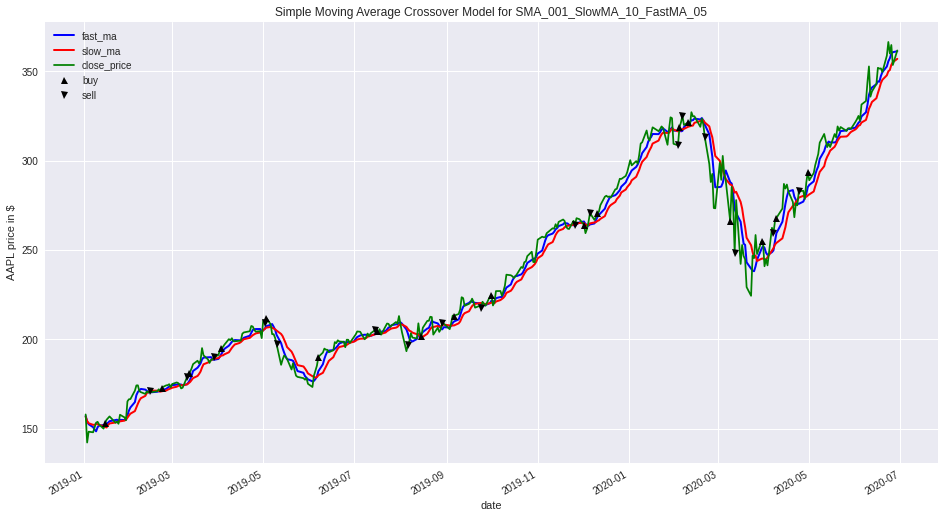

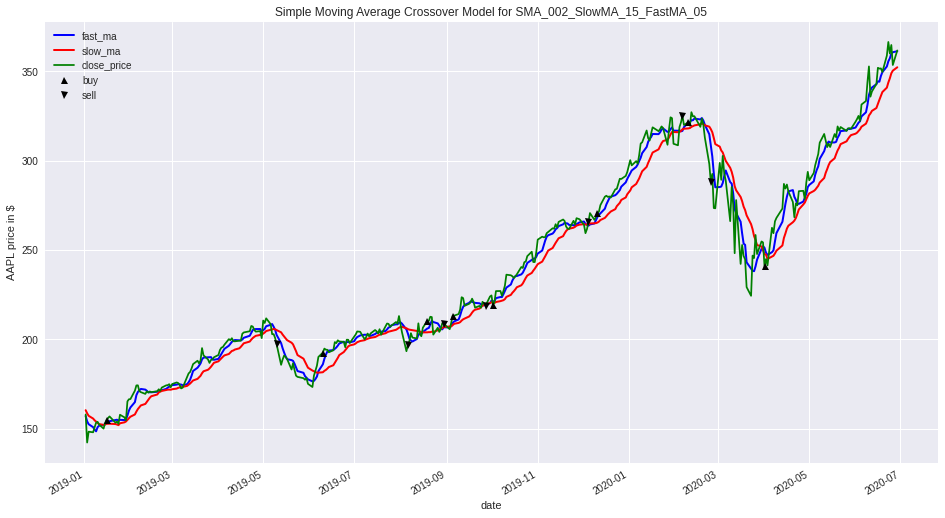

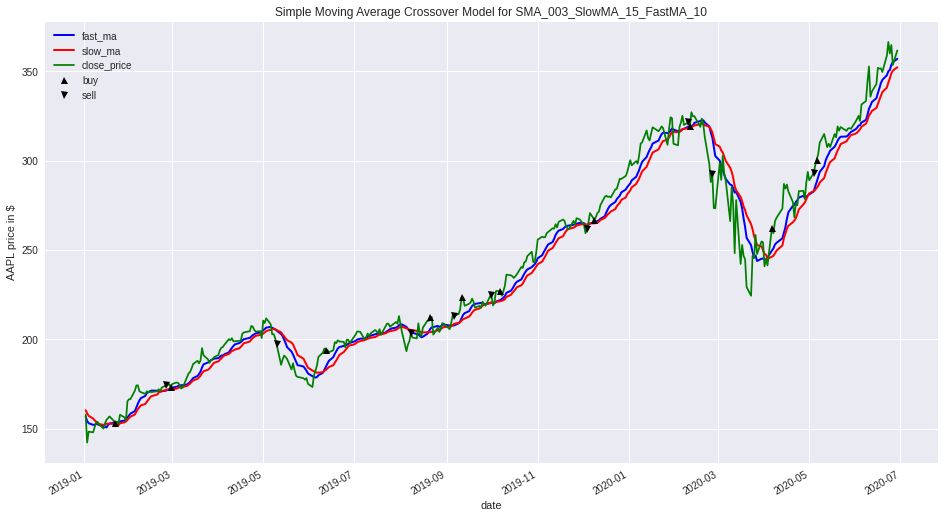

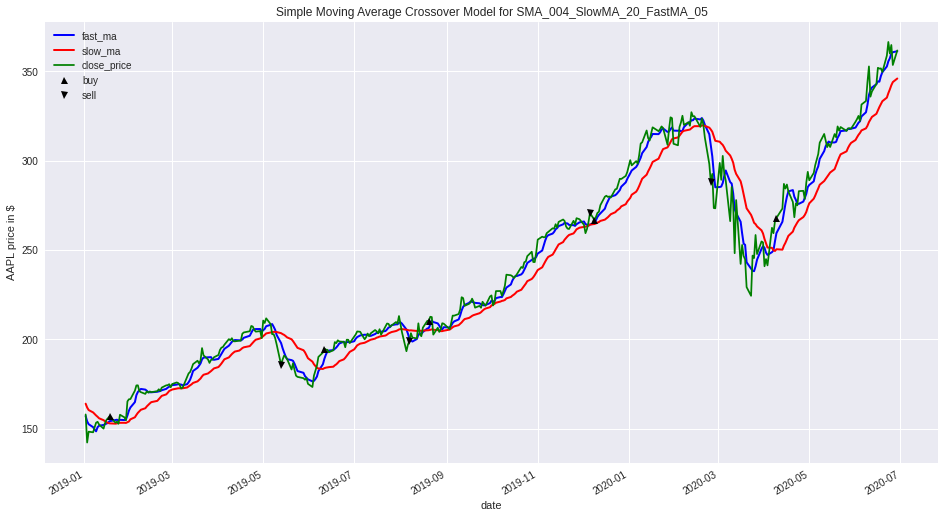

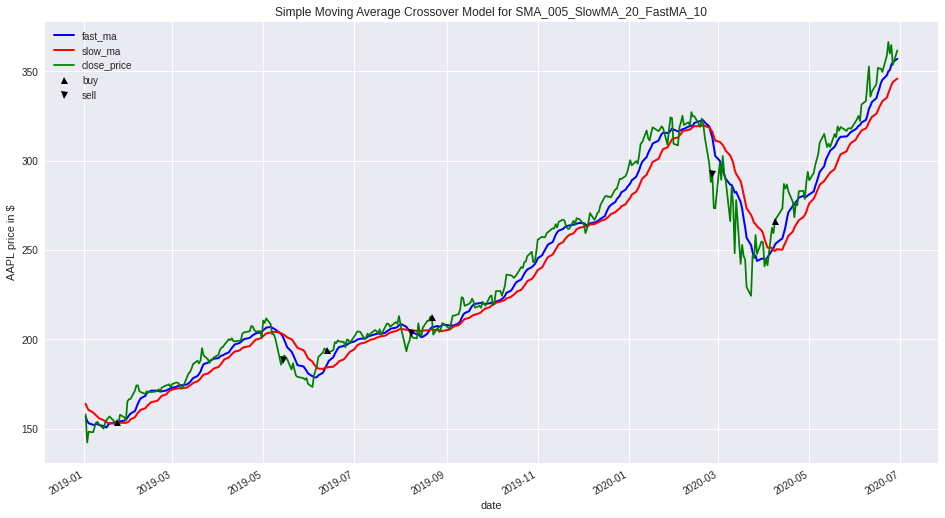

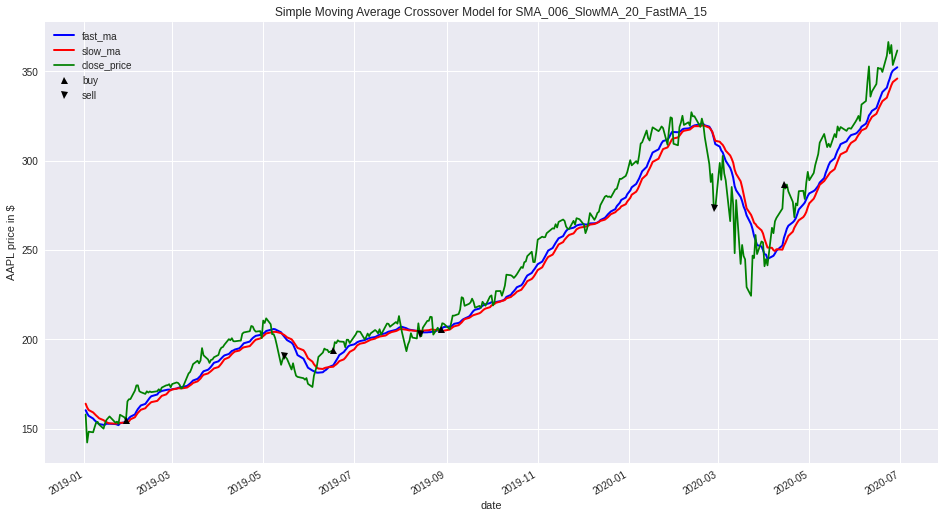

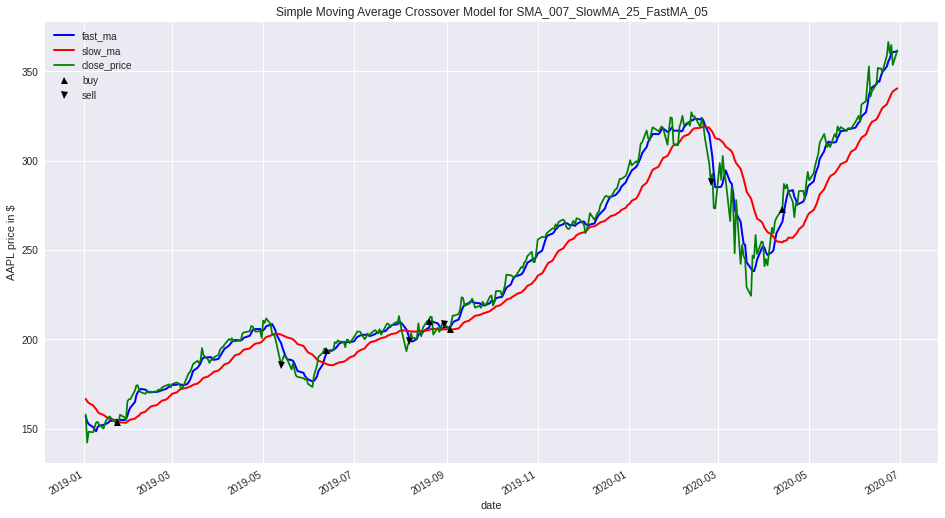

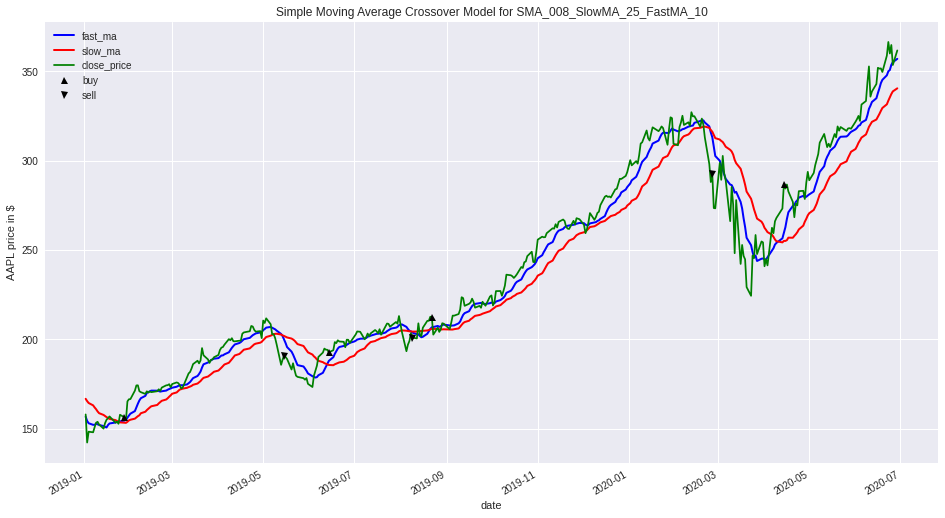

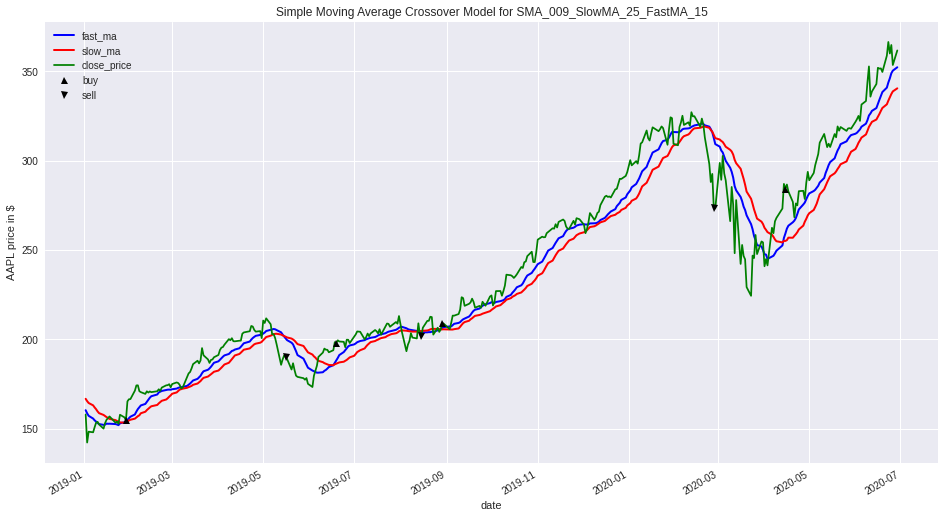

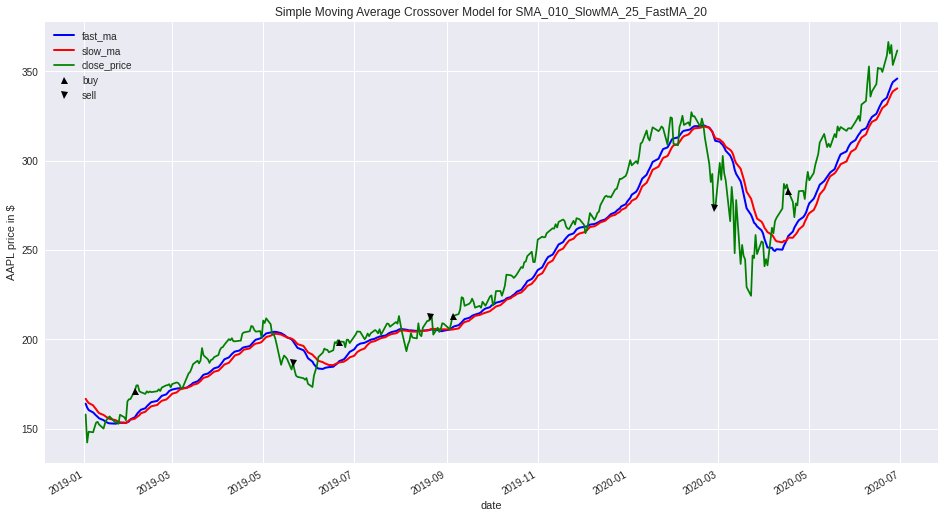

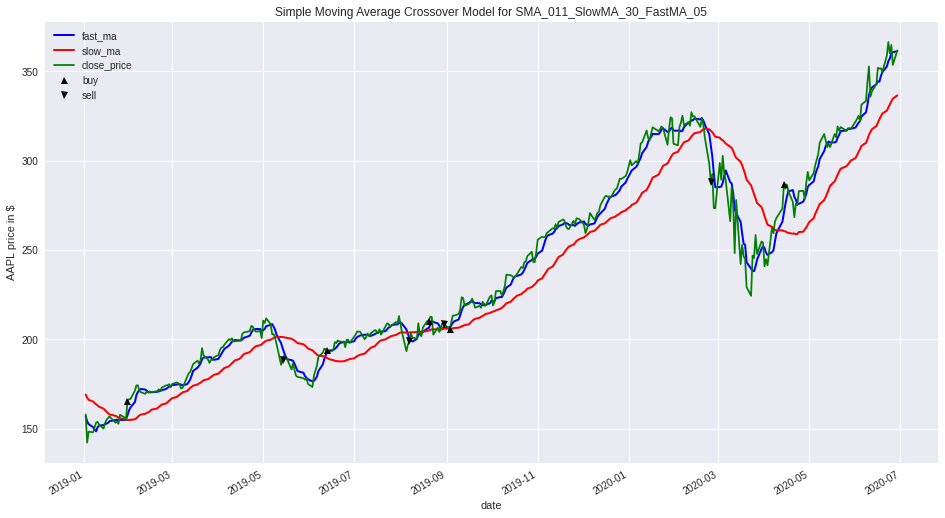

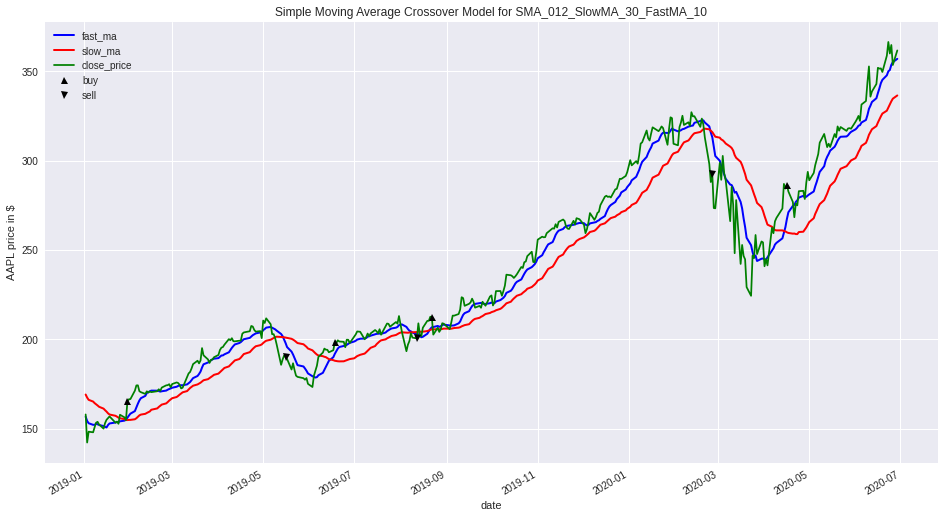

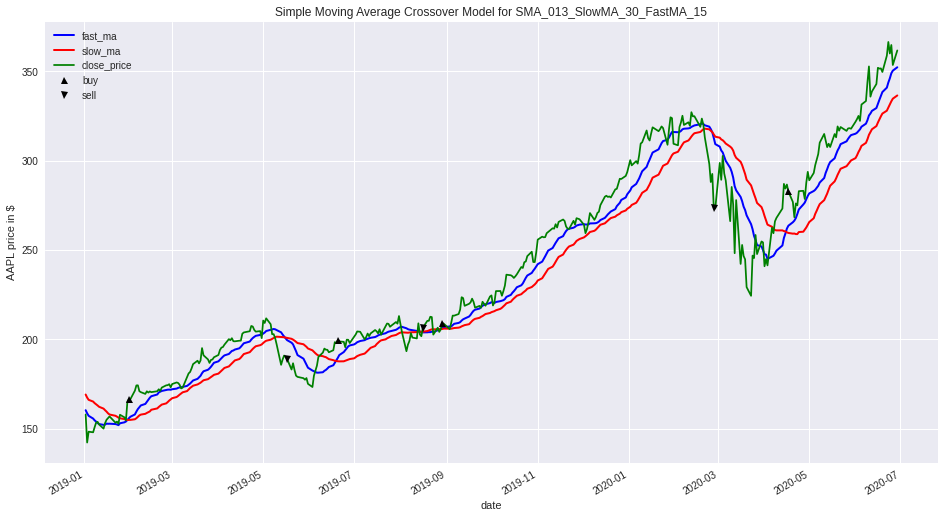

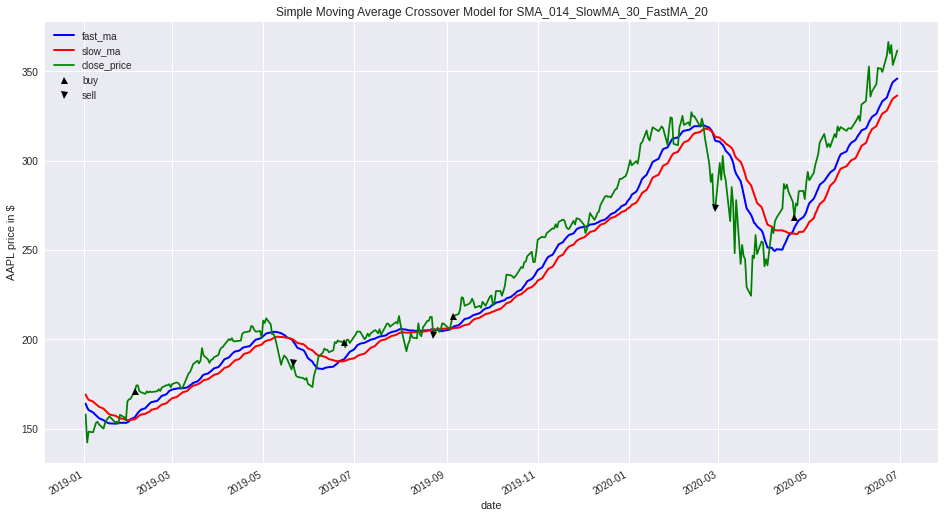

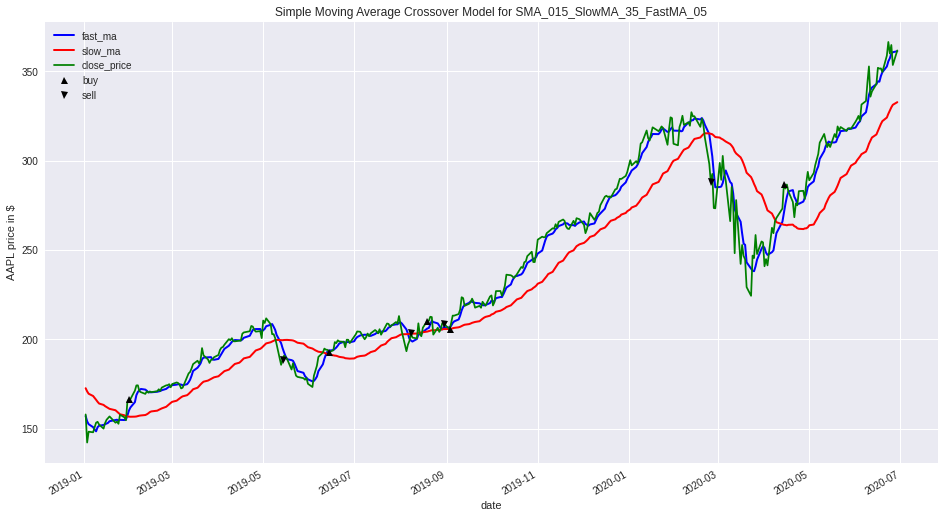

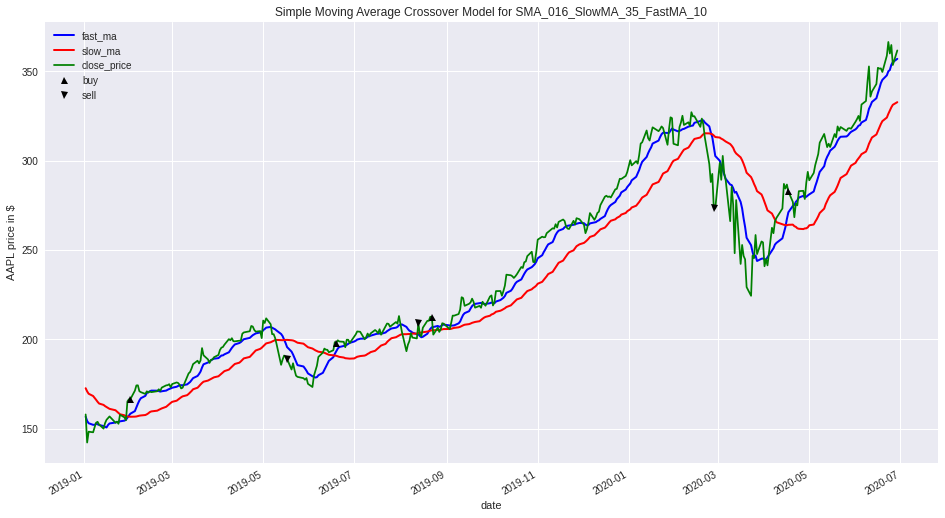

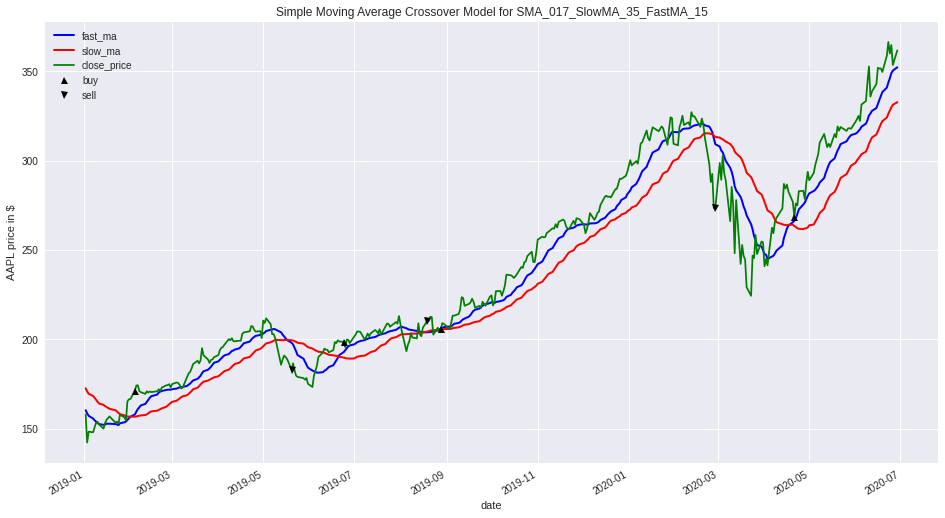

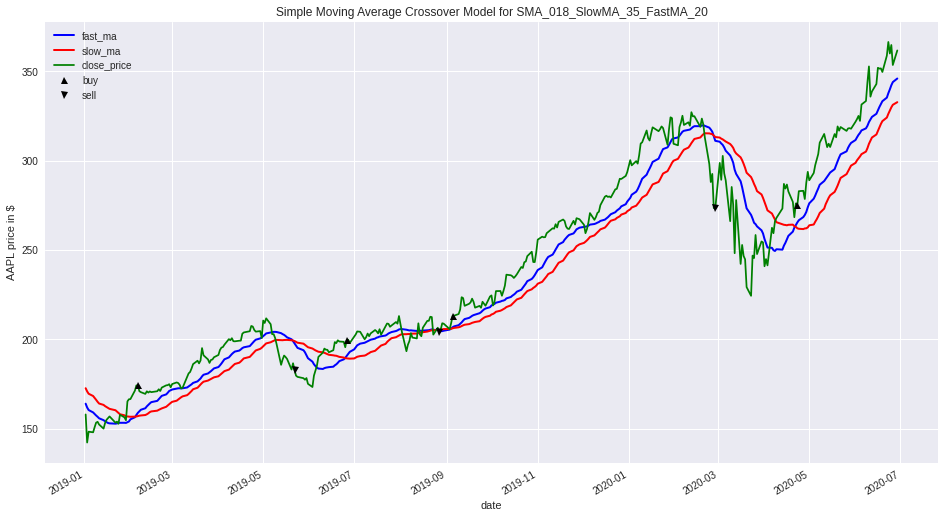

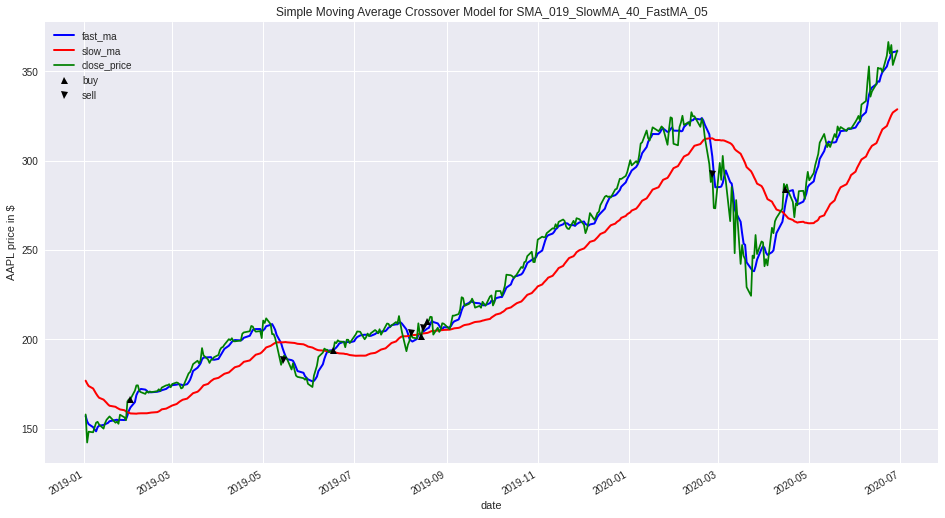

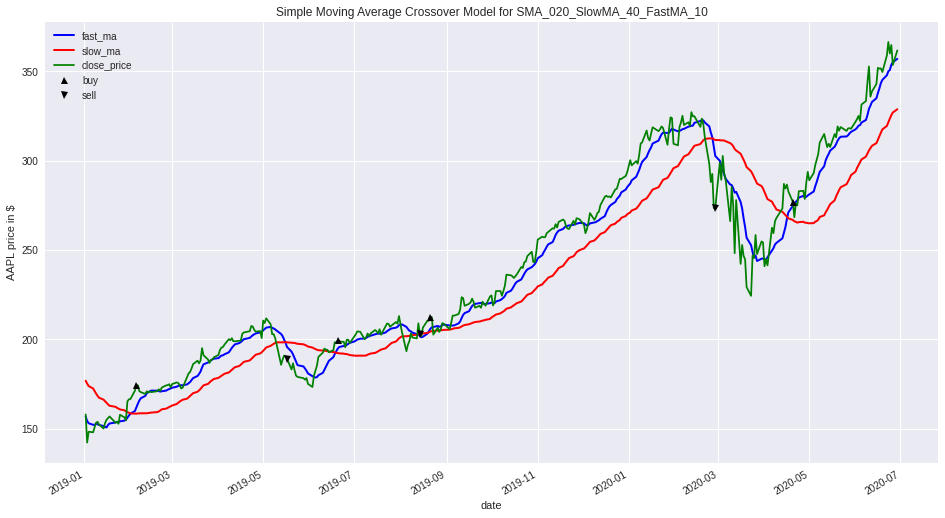

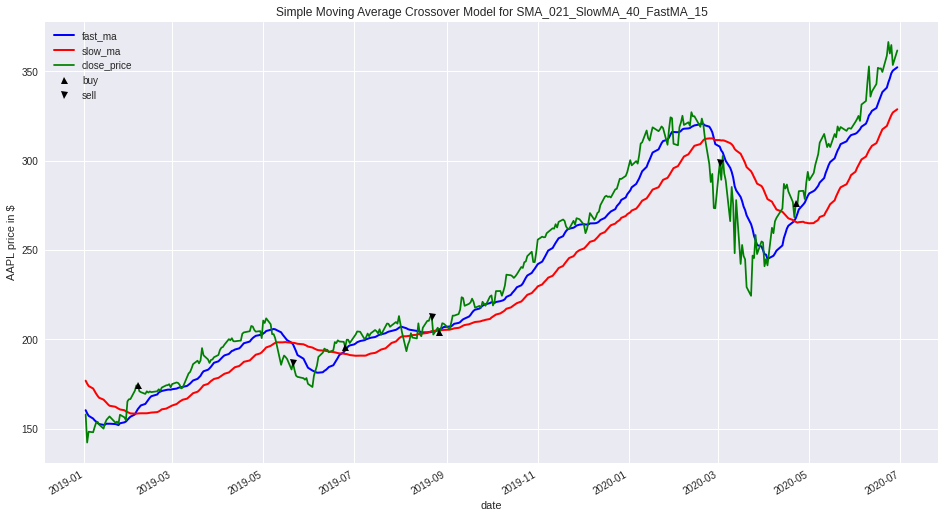

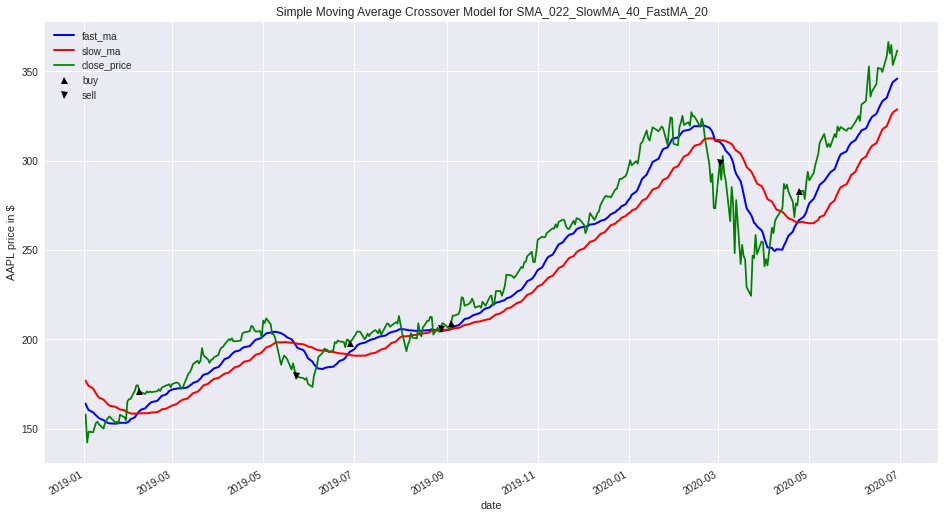

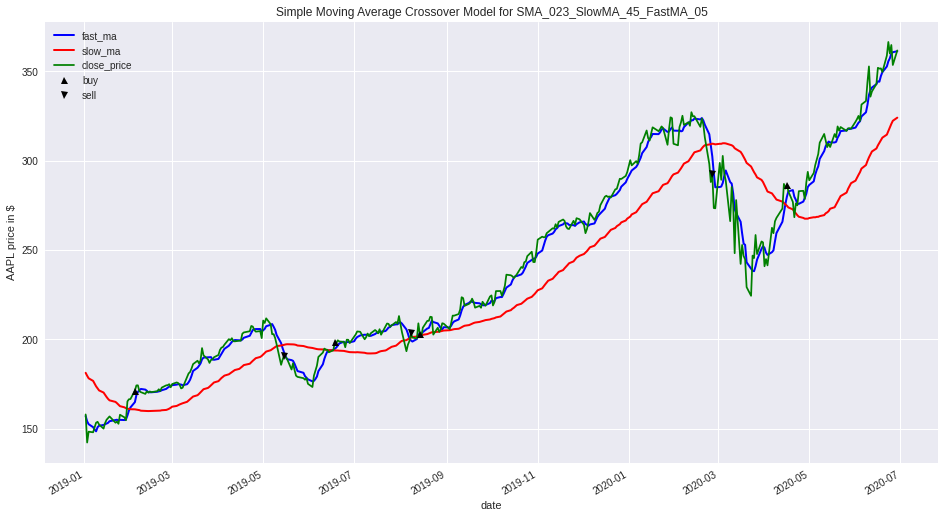

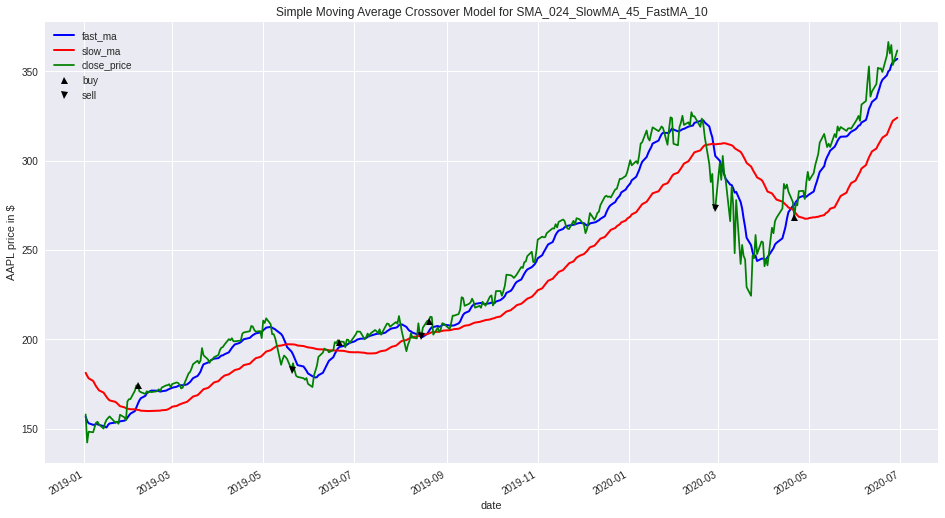

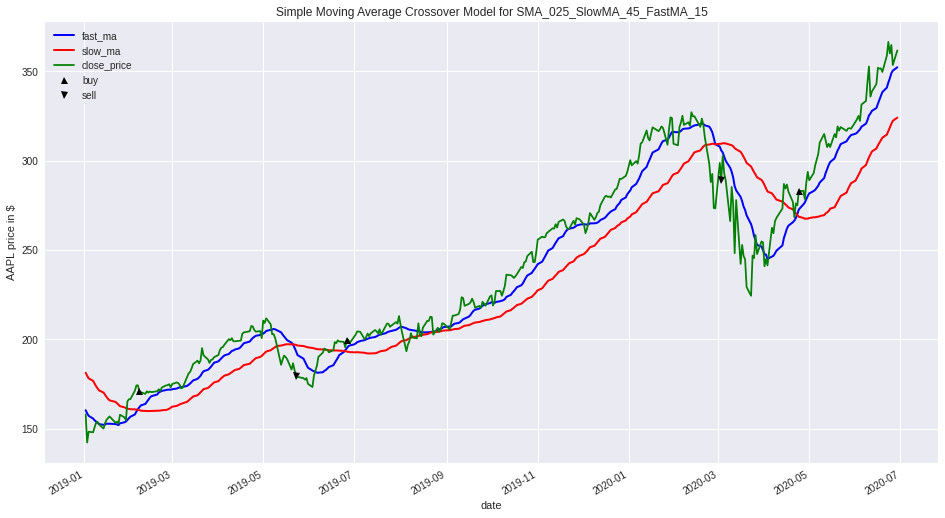

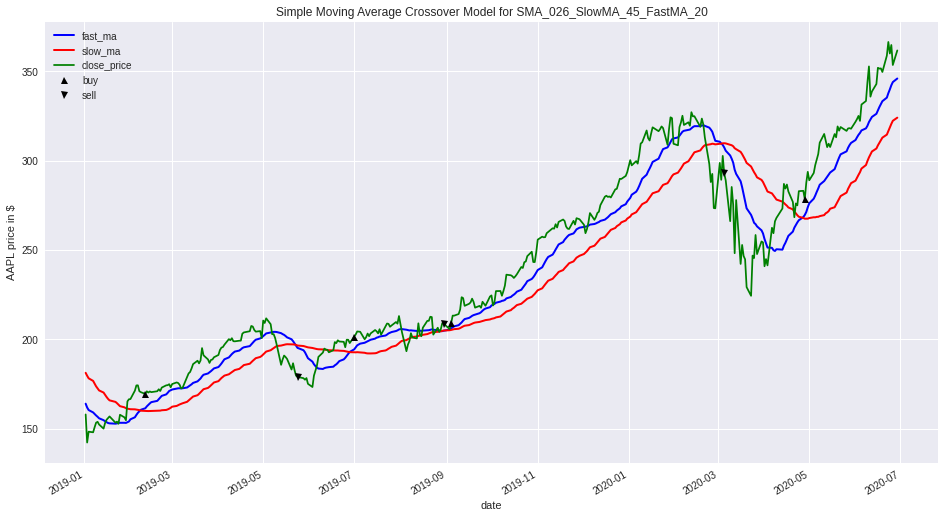

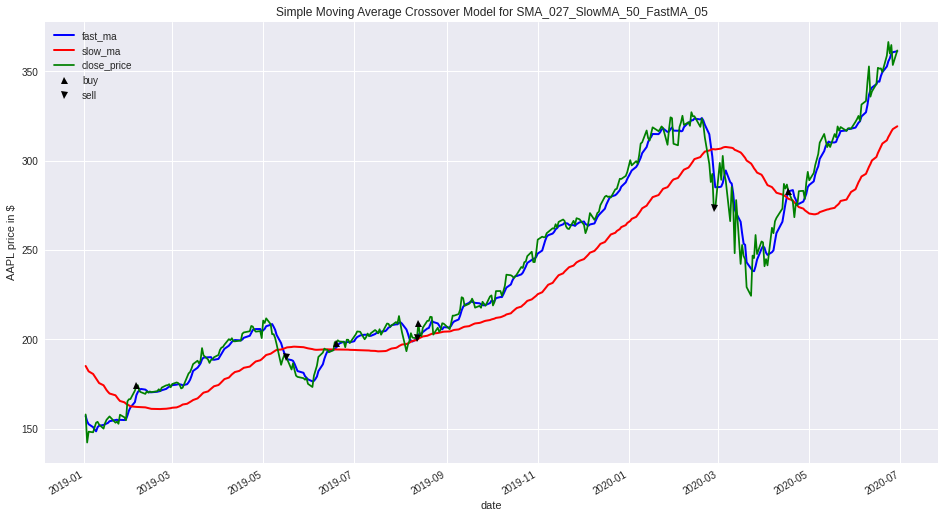

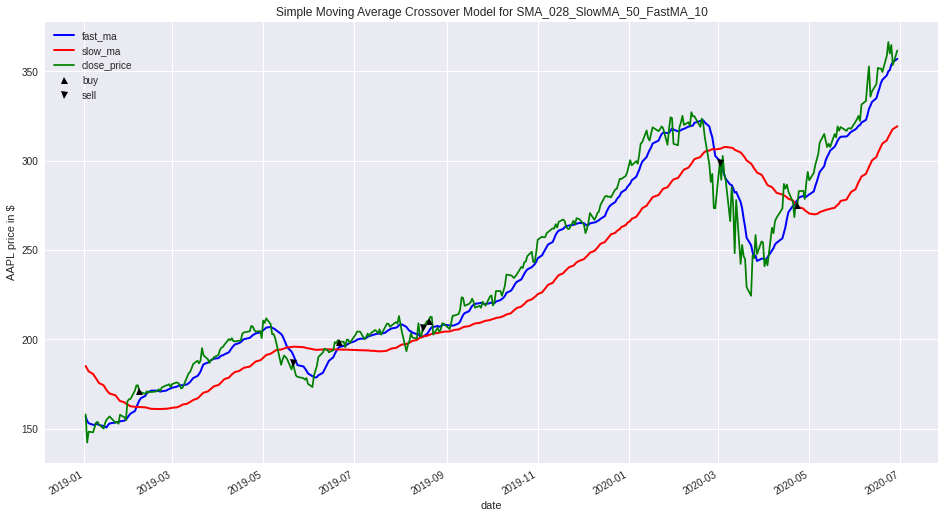

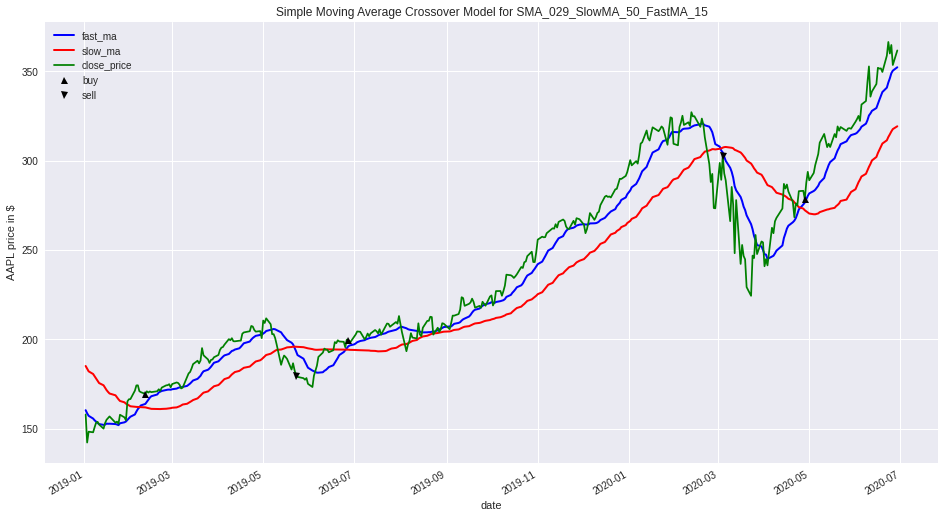

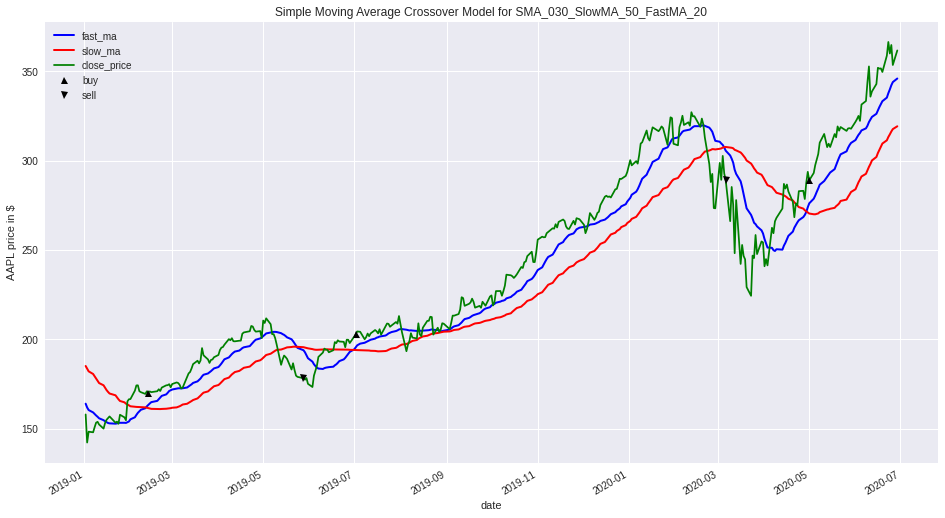

In [19]:
if verbose:
    for key in model_collection:
        graph_data = model_collection[key].copy()
        title_string = "Simple Moving Average Crossover Model for " + key
        fig = plt.figure(figsize=(16,9))
        ylabel = stock_symbol + ' price in $'
        ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
        graph_data['fast_ma'].plot(ax=ax1, color='b', lw=2.)
        graph_data['slow_ma'].plot(ax=ax1, color='r', lw=2.)
        graph_data['close_price'].plot(ax=ax1, color='g')
        ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
        ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
        plt.legend(loc='upper left')
        plt.show()

## Task 4. Back-test Model

In [20]:
def trading_portfolio_generation(initial_fund, trading_model):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trading_model.index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sold_transaction', 'gain_loss', 'cash_onhand', 'position_value', 'total_position', 'accumu_return'])
    portfolio.iloc[0]['trade_action'] = 0
    portfolio.iloc[0]['qty_onhand'] = 0
    portfolio.iloc[0]['cost_basis'] = 0.00
    portfolio.iloc[0]['sold_transaction'] = 0.00
    portfolio.iloc[0]['gain_loss'] = 0.00
    portfolio.iloc[0]['cash_onhand'] = initial_capital
    portfolio.iloc[0]['position_value'] = 0.00
    portfolio.iloc[0]['total_position'] = initial_capital
    portfolio.iloc[0]['accumu_return'] = portfolio.iloc[0]['total_position'] - initial_fund
    recent_cost = 0

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        if (trading_model.iloc[i]['entry_exit'] == 1) and (portfolio.iloc[i-1]['qty_onhand'] == 0):
            portfolio.iloc[i]['trade_action'] = 1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['cost_basis']
            recent_cost = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            if verbose: print('BOUGHT QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trading_model.iloc[i]['open_price'])
        elif (trading_model.iloc[i]['entry_exit'] == -1) and (portfolio.iloc[i-1]['qty_onhand'] > 0):
            portfolio.iloc[i]['trade_action'] = -1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = 0.00
            portfolio.iloc[i]['sold_transaction'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'] * -1
            portfolio.iloc[i]['gain_loss'] = (recent_cost + (trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'])) * -1
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] + portfolio.iloc[i]['sold_transaction']
            recent_cost = 0.00
            if verbose: print('SOLD QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trading_model.iloc[i]['open_price'])
        else:
            portfolio.iloc[i]['trade_action'] = 0
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
            portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand']
        portfolio.iloc[i]['position_value'] = trading_model.iloc[i]['close_price'] * portfolio.iloc[i]['qty_onhand']
        portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_onhand'] + portfolio.iloc[i]['position_value']
        portfolio.iloc[i]['accumu_return'] = portfolio.iloc[i]['total_position'] - initial_fund

    return portfolio

In [21]:
portfolio_collection = {}

# Build dataframe for reporting model performance summary
performance_summary = pd.DataFrame(columns=['model_name','return_value','return_percent'])

for key in model_collection:
    print('Processing portfolio for model:', key)
    portfolio_collection[key] = trading_portfolio_generation(initial_capital, model_collection[key])
    trade_transactions = portfolio_collection[key][portfolio_collection[key].trade_action != 0]
    print(trade_transactions)
    print('Accumulated profit/loss for one share of stock with initial capital of $%.0f at the end of modeling period: $%.2f' % (initial_capital, portfolio_collection[key].accumu_return[-1]))
    if initial_capital != 0:
        return_percentage = portfolio_collection[key].accumu_return[-1] / initial_capital * 100
        print('Accumulated return percentage based on the initial capital investment: %.2f%%' % (return_percentage))
    else:
        return_percentage = None
    if trade_transactions.iloc[-1]['trade_action'] == 1:
        print('The current status of the model is:', 'Holding a position since', trade_transactions.index.tolist()[-1], '\n')
    else:
        print('The current status of the model is:', 'Waiting to enter since', trade_transactions.index.tolist()[-1], '\n')
    performance_summary = performance_summary.append({'model_name': key, 'return_value': portfolio_collection[key].accumu_return[-1],
                                                      'return_percent': return_percentage}, ignore_index=True)

Processing portfolio for model: SMA_001_SlowMA_10_FastMA_05
BOUGHT QTY: 1 on 2019-01-15 00:00:00 at the price of 150.27
SOLD QTY: -1 on 2019-02-14 00:00:00 at the price of 169.71
BOUGHT QTY: 1 on 2019-02-22 00:00:00 at the price of 171.58
SOLD QTY: -1 on 2019-03-11 00:00:00 at the price of 175.49
BOUGHT QTY: 1 on 2019-03-12 00:00:00 at the price of 180.0
SOLD QTY: -1 on 2019-03-29 00:00:00 at the price of 189.83
BOUGHT QTY: 1 on 2019-04-03 00:00:00 at the price of 193.25
SOLD QTY: -1 on 2019-05-02 00:00:00 at the price of 209.84
BOUGHT QTY: 1 on 2019-05-03 00:00:00 at the price of 210.89
SOLD QTY: -1 on 2019-05-10 00:00:00 at the price of 197.419
BOUGHT QTY: 1 on 2019-06-07 00:00:00 at the price of 186.51
SOLD QTY: -1 on 2019-07-15 00:00:00 at the price of 204.09
BOUGHT QTY: 1 on 2019-07-16 00:00:00 at the price of 204.59
SOLD QTY: -1 on 2019-08-06 00:00:00 at the price of 196.31
BOUGHT QTY: 1 on 2019-08-15 00:00:00 at the price of 203.46
SOLD QTY: -1 on 2019-08-29 00:00:00 at the pric

In [22]:
# Display the model performance summary
performance_summary.sort_values(by=['return_value'], inplace=True, ascending=False)
print(performance_summary)

                     model_name  return_value return_percent
1   SMA_002_SlowMA_15_FastMA_05       253.459           None
0   SMA_001_SlowMA_10_FastMA_05       239.484           None
6   SMA_007_SlowMA_25_FastMA_05       222.290           None
3   SMA_004_SlowMA_20_FastMA_05       211.390           None
4   SMA_005_SlowMA_20_FastMA_10       210.140           None
14  SMA_015_SlowMA_35_FastMA_05       204.795           None
10  SMA_011_SlowMA_30_FastMA_05       199.450           None
5   SMA_006_SlowMA_20_FastMA_15       199.060           None
24  SMA_025_SlowMA_45_FastMA_15       197.880           None
2   SMA_003_SlowMA_15_FastMA_10       196.659           None
7   SMA_008_SlowMA_25_FastMA_10       195.355           None
8   SMA_009_SlowMA_25_FastMA_15       189.420           None
20  SMA_021_SlowMA_40_FastMA_15       187.920           None
18  SMA_019_SlowMA_40_FastMA_05       182.860           None
28  SMA_029_SlowMA_50_FastMA_15       181.600           None
22  SMA_023_SlowMA_45_Fa

In [23]:
# Display the transactions from the top model
top_model = performance_summary.iloc[0]['model_name']
print('The transactions from the top model %s:' % (top_model))
print(portfolio_collection[top_model][portfolio_collection[top_model].trade_action != 0])

The transactions from the top model SMA_002_SlowMA_15_FastMA_05:
           trade_action qty_onhand cost_basis sold_transaction gain_loss  \
date                                                                       
2019-01-16            1          1     153.08                0         0   
2019-05-10           -1          0          0          197.419    44.339   
2019-06-10            1          1     191.81                0         0   
2019-08-06           -1          0          0           196.31       4.5   
2019-08-19            1          1     210.62                0         0   
2019-08-30           -1          0          0           210.16     -0.46   
2019-09-05            1          1        212                0         0   
2019-09-27           -1          0          0           220.54      8.54   
2019-10-02            1          1     223.06                0         0   
2019-12-05           -1          0          0           263.79     40.73   
2019-12-11            1

In [24]:
# Display the entry and exit signals for the top model
print('The trading signal changes from the top model %s:' % (top_model))
print(model_collection[top_model][model_collection[top_model].signal_change != 0])

The trading signal changes from the top model SMA_002_SlowMA_15_FastMA_05:
            open_price  close_price  fast_ma     slow_ma  ma_change  \
date                                                                  
2019-01-15      150.27       153.07  152.494  152.242667   0.251333   
2019-05-09      200.40       200.72  205.342  205.618000  -0.276000   
2019-06-07      186.51       190.15  182.170  181.328667   0.841333   
2019-08-05      197.99       193.34  205.522  206.192000  -0.670000   
2019-08-16      204.28       206.50  204.088  203.879333   0.208667   
2019-08-29      208.50       209.01  205.566  206.338000  -0.772000   
2019-09-04      208.39       209.19  207.634  207.217333   0.416667   
2019-09-26      220.00       219.89  219.010  219.262333  -0.252333   
2019-10-01      225.07       224.59  221.660  220.812333   0.847667   
2019-12-04      261.07       261.74  264.088  264.289333  -0.201333   
2019-12-10      268.60       268.48  266.686  265.070667   1.615333   
20

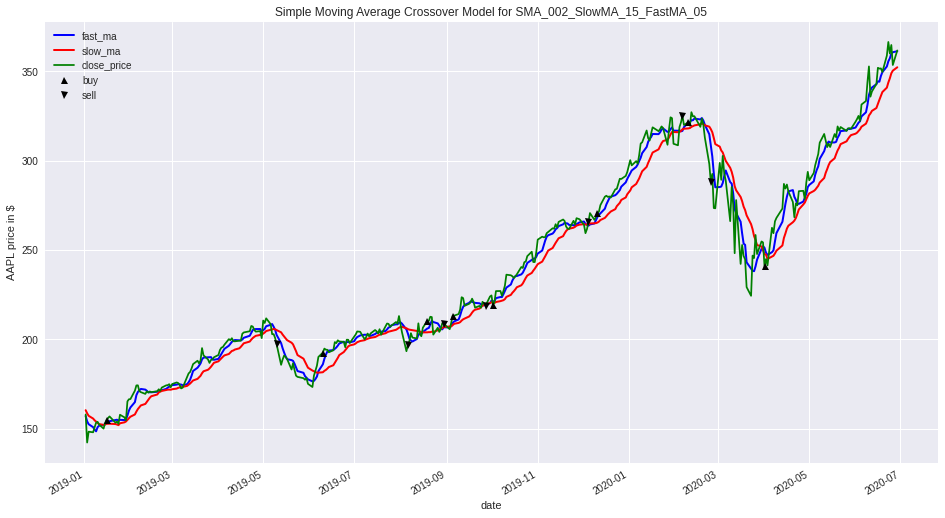

In [25]:
graph_data = model_collection[top_model].copy()
title_string = "Simple Moving Average Crossover Model for " + top_model
fig = plt.figure(figsize=(16,9))
ylabel = stock_symbol + ' price in $'
ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
graph_data['fast_ma'].plot(ax=ax1, color='b', lw=2.)
graph_data['slow_ma'].plot(ax=ax1, color='r', lw=2.)
graph_data['close_price'].plot(ax=ax1, color='g')
ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
plt.legend(loc='upper left')
plt.show()

## Task 5. Evaluate Performance

In [26]:
best_model = ''
best_return = 0
for key in portfolio_collection:
    if portfolio_collection[key]['accumu_return'][-1] > best_return:
        best_model = key
        best_return = portfolio_collection[best_model]['accumu_return'][-1]
print('The best model found is:', best_model)
print('The best profit/loss for the investing period is: $%.2f' % (best_return))
if initial_capital != 0:
    print('The best return percentage for initial capital is: %.2f%%' % (best_return / initial_capital * 100))

The best model found is: SMA_002_SlowMA_15_FastMA_05
The best profit/loss for the investing period is: $253.46


In [27]:
worst_model = None
worst_return = 0
for key in portfolio_collection:
    if portfolio_collection[key]['accumu_return'][-1] < worst_return:
        worst_model = key
        worst_return = portfolio_collection[worst_model]['accumu_return'][-1]
print('The worst model found is:', worst_model)
print('The worst profit/loss for the investing period is: $%.2f' % (worst_return))
if initial_capital != 0:
    print('The worst return percentage for the initial capital is: %.2f%%' % (worst_return / initial_capital * 100))

The worst model found is: None
The worst profit/loss for the investing period is: $0.00


In [28]:
# Calculate the stock's performance for a long-only model
model_template = model_template[model_start_date:model_end_date]
print('The performance of the long-only model from day one is: $%.2f' %(model_template.iloc[-1]['close_price'] - model_template.iloc[0]['open_price']))

The performance of the long-only model from day one is: $206.89


In [29]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:42.567441
